In [6]:
import clickhouse_connect
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os

# Load environment variables
load_dotenv()

# Connect to ClickHouse database using environment variables
ch_client = clickhouse_connect.get_client(
    host=os.getenv("CLICKHOUSE_HOST"),
    port=int(os.getenv("CLICKHOUSE_PORT")),
    username=os.getenv("CLICKHOUSE_USERNAME"),
    password=os.getenv("CLICKHOUSE_PASSWORD"),
)


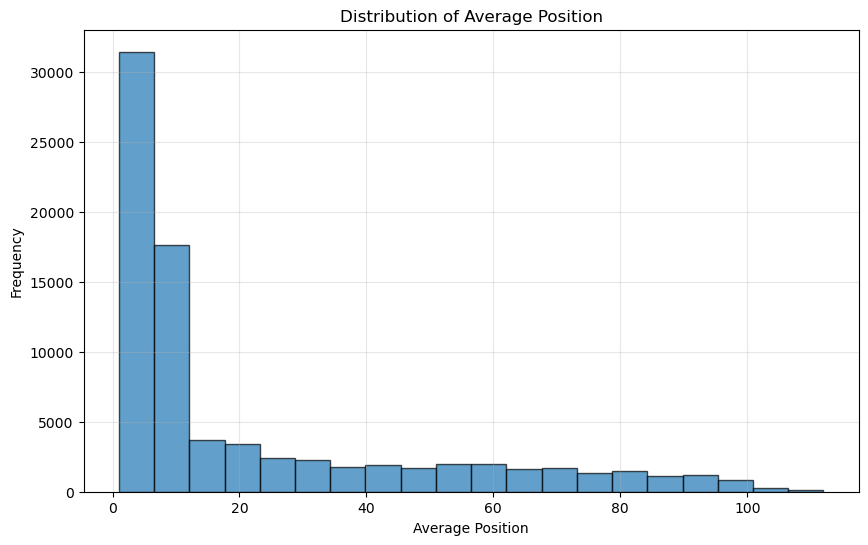

In [ ]:
import pandas as pd

# Query the data
query = "SELECT average_position FROM ahrefs.keywords"
df = ch_client.query_df(query)

# Create the distribution plot
plt.figure(figsize=(10, 6))
plt.hist(
    df["average_position"],
    bins=20,
    alpha=0.7,
    # range=(0.0, 20.0),
    edgecolor="black",
    # log=True,
)
plt.xlabel("Average Position")
plt.ylabel("Frequency")
plt.title("Distribution of Average Position")
plt.grid(True, alpha=0.3)
plt.show()


In [11]:
query = "SELECT keyword, website, average_position FROM ahrefs.keywords where average_position < 4"
df = ch_client.query_df(query)

low_ranks = df
low_ranks

,keyword,website,average_position
0,gravity 1 rocket,ana.ir,3.0
1,gravity-1,ana.ir,3.0
2,iranian currency,ana.ir,2.0
3,new zealand versus,ana.ir,1.0
4,solor storm,ana.ir,1.0
...,...,...,...
18392,کد بسته شبانه ایرانسل,zoomtech.org,1.0
18393,کد مکالمه رایگان ایرانسل,zoomtech.org,1.0
18394,کدام تلویزیون ها جیوه دارند,zoomtech.org,3.0
18395,یک ایمیل,zoomtech.org,2.0


In [12]:
low_ranks["website"].unique()

<StringArray>
[                'ana.ir',            'anzalweb.ir',         'arzdigital.com',
        'asre5shanbe.com',        'cryptonegar.com',            'digiato.com',
            'diginoy.com',    'donya-e-eqtesad.com',           'drpharmo.com',
           'iranrich.com',            'itresan.com',       'jamejamonline.ir',
    'mihanblockchain.com',        'mihansignal.com',           'persianv.com',
             'pulbank.ir',          'razebaghaa.ir',           'safarpin.com',
           'talaangor.ir',           'techrato.com',              'utofx.com',
        'www.asriran.com',       'www.beytoote.com',         'www.chetor.com',
        'www.delgarm.com',   'www.hamyarcrypto.com',            'www.irna.ir',
   'www.khabargardoon.ir',    'www.khabaronline.ir',         'www.kojaro.com',
    'www.mashreghnews.ir',      'www.niksalehi.com',        'www.samatak.com',
    'www.sharghdaily.com',          'www.tabnak.ir',          'www.talab.org',
     'www.tasnimnews.com', 'www.tasvir

In [16]:
query = "SELECT website, min(average_position) FROM ahrefs.keywords group by website"
df = ch_client.query_df(query)
df

,website,min(average_position)
0,utofx.com,1.0
1,www.chetor.com,1.0
2,footofan.com,5.0
3,nasrino.ir,4.0
4,www.talab.org,1.0
5,mediat.ir,5.0
6,www.khabaronline.ir,1.0
7,www.beytoote.com,1.0
8,jamejamonline.ir,1.0
9,www.tabnak.ir,1.0


In [5]:
low_ranks

,average_position
98,3.0
99,3.0
122,2.0
159,1.0
233,1.0
...,...
79788,1.0
79821,1.0
79827,3.0
79958,2.0


In [ ]:
query = "SELECT keyword, volume, average_position, website FROM ahrefs.keywords"
df = ch_client.query_df(query)


In [20]:
df["keyword"].unique

<bound method Series.unique of 0                 0033 کد کدام کشور است
1        100 تا از بهترین بازیکنان جهان
2                  1001 نام خدا با معنی
3                                 10125
4                       3d printer food
                      ...              
79967                               ۱۴۱
79968                       ۱۹۲.۱۶۸.۱.۱
79969               ۱۹۲.۱۶۸.۱.۱ با گوشی
79970                          ۳۶۰ سپهر
79971                          아웃룩 이모티콘
Name: keyword, Length: 79972, dtype: string>

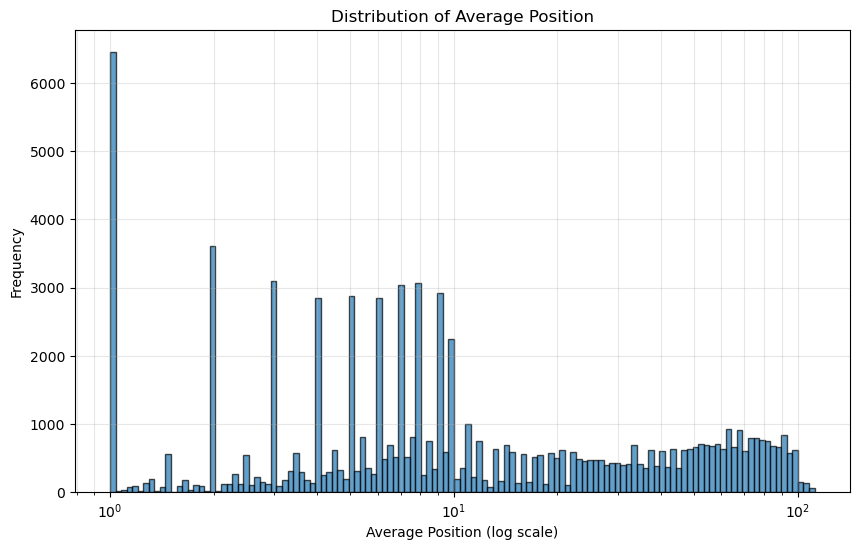

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Query the data
query = "SELECT average_position FROM ahrefs.keywords"
df = ch_client.query_df(query)

data = df["average_position"]  # [df["average_position"]]

# Define exponentially spaced bins
num_bins = 128
bins = np.logspace(0.0, np.log10(data.max()), num_bins)  # 20 bins

# Create histogram with exponential bins
plt.figure(figsize=(10, 6))
plt.hist(data, bins=bins, alpha=0.7, edgecolor="black")

plt.xscale("log")  # Set x-axis to logarithmic
plt.xlabel("Average Position (log scale)")
plt.ylabel("Frequency")
plt.title("Distribution of Average Position")
plt.grid(True, alpha=0.3, which="both")
plt.show()


In [ ]:
from embedding import OllamaEmbedding


embedding = OllamaEmbedding()

In [ ]:
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams
from sentence_transformers import SentenceTransformer

# 1. Connect to Qdrant
ch_client = QdrantClient("http://localhost:6333")

# 2. Load your embedding model
model = SentenceTransformer("MCINext/Hakim")

# 3. Create a collection
ch_client.recreate_collection(
    collection_name="fa_keywords",
    vectors_config=VectorParams(size=768, distance=Distance.COSINE),
)

# 4. Prepare data
texts = ["آیفون ۱۶", "آیفون ۱۵", "هندزفری", "گوشی همراه", "سامسونگ a54", "طلا", "نقره"]
vectors = model.encode(texts).tolist()

# 5. Upload to Qdrant
ch_client.upsert(
    collection_name="fa_keywords",
    points=[
        {"id": i, "vector": vec, "payload": {"text": text}}
        for i, (text, vec) in enumerate(zip(texts, vectors))
    ],
)

# 6. Query
query = "آیفون"
query_vec = model.encode([query])[0].tolist()

results = ch_client.search(
    collection_name="fa_keywords", query_vector=query_vec, limit=5
)

for r in results:
    print(r.payload["text"], "→", r.score)
